In [1]:
# Import general packages.

import tensorflow as tf
import numpy as np
import os
import matplotlib.pyplot as plt
import time
from typing import List
from skimage import exposure

tfe = tf.contrib.eager

tf.enable_eager_execution()

In [44]:
# Import project libraries.

import sys
sys.path.insert(0, '/Users/noah/Documents/CHU/Ultrasound/lib/')

from image_registration import loss_utils
from image_registration import load_image
from image_registration import warp
from image_registration import elastic_image
from image_registration import warp_utils
from image_registration import rigid_registration
from image_registration import elastic_image_utils

from image_utils import visualization_utils



In [87]:
dataset_path = "/Users/noah/Documents/CHU/Ultrasound/raw_data/heart_rotation"

save_dir = "/Users/noah/Documents/CHU/Ultrasound/experiment_results/9_17_registration"

if not os.path.exists(save_dir):
  os.makedirs(save_dir)

images_file = os.path.join(dataset_path, 'raw_images.npy')
data_temp = np.load(images_file).astype(np.float32)

print(data_temp.shape)


(9, 623, 512)


In [39]:
def load_single_image(
    image,
    rotation,
    translation,
    control_points = (5, 5),
    ):
    
    image = tf.convert_to_tensor(image)

    total_size = tf.cast(tf.shape(image), tf.float32)

    xx, yy = tf.meshgrid(tf.linspace(0., total_size[0], control_points[0]),
                         tf.linspace(0., total_size[1], control_points[1]))

    control_points = tf.stack([xx, yy], -1)
    control_points = tf.reshape(control_points, [-1, 2])

    return load_image.load_image(image, control_points, rotation, translation, 1.)


In [241]:
def warped_image(
    image,
    include_non_rigid = False,
    log = True
    ):
    prepared_warp_values = warp_utils.warp_tensor(image, True, True, include_non_rigid)

    image_warp, _ = warp.sparse_warp(
        image.image[tf.newaxis, :, :, tf.newaxis],
        image.control_points[tf.newaxis, :, :],
        prepared_warp_values, 
        1.)
    
    image = image_warp[0, :, :, 0].numpy()
    
    if log:
        return exposure.adjust_log(image)
    else:
        return image


def compare_images(
    image_a,
    image_b
    ):
    
    image_a_warp = warped_image(image_a, True)
    
    image_b_warp = warped_image(image_b, True)
    image_b_before_registration = warped_image(image_b, False)
    
    fig, ax = plt.subplots(1,2, figsize=(15,15))
    ax[0].imshow(visualization_utils.multiple_intensity_to_rgb(image_a_warp, image_b_before_registration))
    ax[1].imshow(visualization_utils.multiple_intensity_to_rgb(image_a_warp, image_b_warp))
    fig.savefig(os.path.join(save_dir, "warped_image"))


In [244]:
def register(
    image_a,
    image_b,
    scales: List[int],
    steps: List[int]
    ):
    """Registeres `image_b` onto `image_a`."""
    if not len(scales) == len(steps):
        raise ValueError("Scales and `steps` must have same lengt, got {}".format([len(scales), len(steps)]))

    global_step = tfe.Variable(0)
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate,
                                       beta1=beta,
                                       beta2=beta_2,
                                       )
    
    translation_optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate/10,
                                       beta1=beta,
                                       beta2=beta_2,
                                       )

    time_start = time.time()
    for scale, num_steps in zip(scales, steps):
        for step in range(num_steps):

          with tfe.GradientTape(persistent=True) as tape:
            num_query_points = int( 1000 / scale)
            query_points = tf.concat(
              [tf.random_uniform([1, num_query_points, 1], 0, 600),
               tf.random_uniform([1, num_query_points, 1], 0, 600)], -1)
            
            # Track only non-rigid warp for optimization.
            prepared_warp_values = warp_utils.warp_tensor(image_a, True, True, True)
            
            warped_values = warp.warp_query(
              image_a.image[tf.newaxis, :, :, tf.newaxis],
              query_points,
              image_a.control_points[tf.newaxis, :, :],
              prepared_warp_values,
              scale,
            )
            
            prepared_warp_values = warp_utils.warp_tensor(image_b, True, True, True)

            truth_vals = warp.warp_query(
              image_b.image[tf.newaxis, :, :, tf.newaxis],
              query_points,
              image_b.control_points[tf.newaxis, :, :],
              prepared_warp_values,
              scale,
            )

            mse_loss = loss_utils.masked_mse([warped_values, truth_vals])

            # arp_loss = loss_utils.warp_loss(tf.reshape(image_a.get_list_from_variable_dict("non_rigid"), [1, 3, 3, 2]), 1)

            total_loss = mse_loss
            
            non_rigid = warp_utils.warp_variables(image_b, False, False, True)
#             translation = warp_utils.warp_variables(image_b, True, False, False)



          non_rigid_grads = tape.gradient(total_loss, non_rigid)    
#           translation_grads = tape.gradient(total_loss, translation)
            
          optimizer.apply_gradients(
            zip(non_rigid_grads, non_rigid),
            global_step=global_step)
            
#           translation_optimizer.apply_gradients(
#             zip(translation_grads, translation),
#             global_step=global_step)
          
        

          del tape

    time_end = time.time()
    print("runtime {}".format(time_end - time_start))


In [212]:
list_of_images = [data_temp[slice] for slice in range(data_temp.shape[0])]

rotations, translations = rigid_registration.relative_rotation_and_translation(list_of_images, [10.,11.], 1)


In [286]:
# Append 0 since the first image and translation pair are in the base coordinates.
rotations = [0] + list(rotations)

# Calculate running rotation
running_rotation = np.cumsum(rotations)

# We need to correct for the rotation of the coordinate system
# with each successive image. In other words, because
# the rotation angle is calculated in the coordinates of the
# imediately preceding image, we can not just sum the 
# translations to find the total translation at image i.

# Find correction by projecting the translation term
# onto coordinates defined by the unning rotation. 
corrections_to_translation_from_rotation = [
    warp_utils.rotate_points(
        tf.convert_to_tensor(translation)[tf.newaxis, :],
        tf.convert_to_tensor([0., 0.]),
        tf.convert_to_tensor(rotation)
    )[0, :].numpy()
    for rotation, translation in zip(running_rotation, translations)
]

# Add corrections to translations.
rotation_corrected_translations = [
    translation + correction for translation, correction in zip(translations, corrections_to_translation_from_rotation
                                                               )
]

rotation_corrected_translations = [[0,0]] + rotation_corrected_translations

# Calculate running translation from corrected terms.
running_translation = np.cumsum(rotation_corrected_translations, axis = 0)

runtime 2.1015851497650146
runtime 1.9980392456054688
runtime 1.9803569316864014
runtime 1.9641668796539307
runtime 1.9779698848724365
runtime 2.132147789001465
runtime 2.083193063735962
runtime 2.082728862762451


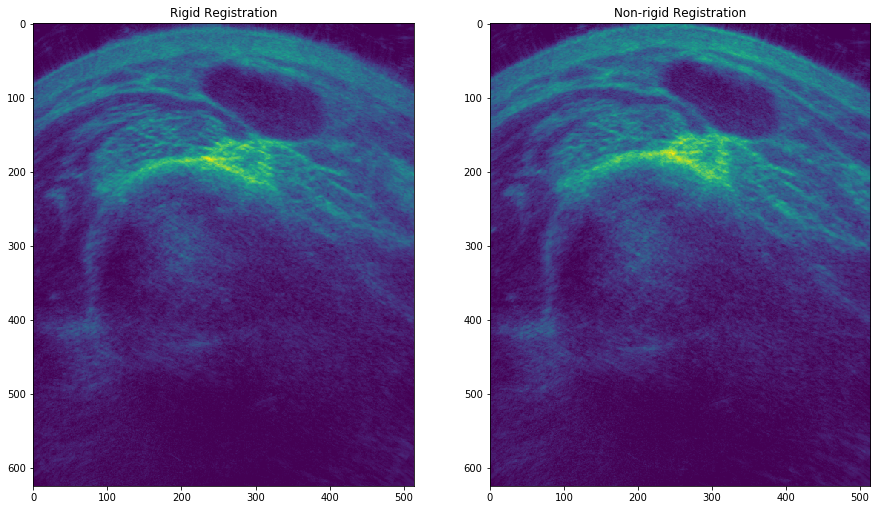

In [290]:
# Load images into list.
images = [
    load_single_image(image, running_rotation[image_number], running_translation[image_number])
    for image_number, image
    in enumerate(list_of_images) 
]

# Add small pad to fix warping artifacts.
for i in images:
    i.image = tf.pad(i.image, [[1,1], [1, 1]], mode='constant')

elastic_image_utils.reduce_rotation(images)
elastic_image_utils.reduce_translation(images)


# Registration parameters.
learning_rate = .5
beta = .4
beta_2 = .99

# Register successive images.
[
    register(image_a, image_b, [4], [60])
    for image_a, image_b 
    in zip(images, images[1:])
]

compare_rigid_and_non_rigid(images)



In [291]:
%prun -l 20 -s cumulative register(image_a, image_b, [4], [60])



runtime 2.6501312255859375
 

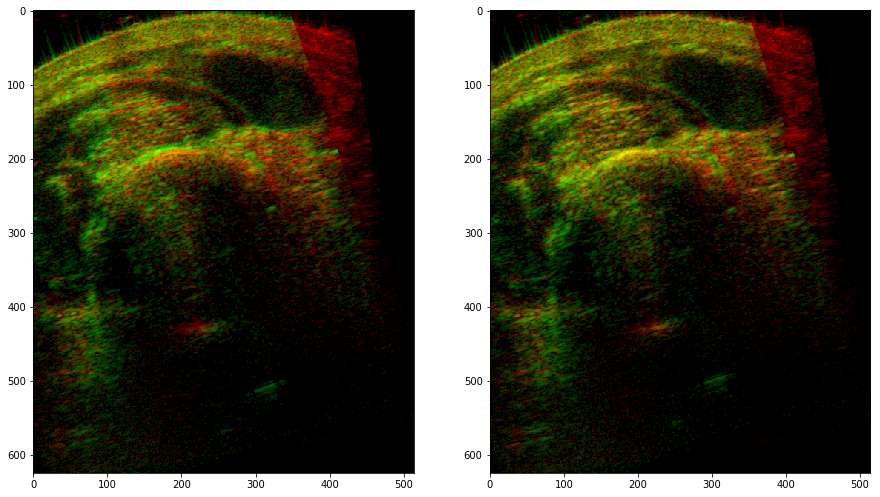

In [289]:
compare_images(images[5], images[6])

In [283]:
def compare_rigid_and_non_rigid(images):
    fig, ax = plt.subplots(1, 2, figsize = (15, 20))
    ax[0].imshow(
        np.sum([warped_image(image) for image in images], axis = 0)
    )
    ax[0].set_title("Rigid Registration")
    ax[1].imshow(
        np.sum([warped_image(image, True) for image in images], axis = 0)
    )
    ax[1].set_title("Non-rigid Registration")

